# PokeAPI Final Project

In [21]:
# Importing all essential libraries. More to be added as project continues
import pandas as pd
import numpy as np
import scipy.stats as stats 
import json
import requests
import matplotlib.pyplot as plt

In [8]:
# Function to fetch a Pokemon's data
def fetch_pokemon_data(pokemon):
    # Extract the pokemon's data
    pokemon_url = pokemon["url"]
    pokemon_resp = requests.get(pokemon_url)
    pokemon_data = pokemon_resp.json()

    # Extracting the pokemon's name, type, and stats from pokemon_data
    name = pokemon_data["name"]
    types = [type['type']['name'] for type in pokemon_data["types"]] # get all types if a pokemon has multiple types
    stats = {stat["stat"]["name"]: stat["base_stat"] for stat in pokemon_data["stats"]} # get all stats as a dictionary (stat["stat"]["name"]: stat["base_stat"] creates a key-value pair in which the name is the key and the base stat is the value)

    # Extracting the pokemon's generation number
    species_url = pokemon_data["species"]["url"]
    species_resp = requests.get(species_url)
    species_data = species_resp.json()
    generation = species_data["generation"]["name"] 

    generation_num = generation.split("-")[-1] # retrieves the last elem of the list generated by split (the roman numeral)
    generation_roman_lst = ["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix"]

    if generation_num in generation_roman_lst:
        index = generation_roman_lst.index(generation_num)
        generation_num = int(generation_num.replace(generation_roman_lst[index], str(index + 1)))

    # Add Pokemon's name and types into the stats dictionary (ensuring they're there if not)
    stats["name"] = name
    stats["types"] = types
    stats["generation"] = generation_num

    return stats # returns as a dictionary
    

In [9]:
# Fetching the API (we are only looking at the first 493 Pokemon, Gens 1-4)
api_url = "https://pokeapi.co/api/v2/pokemon?limit=493&offset=0"
response = requests.get(api_url)
pokeapi_data = response.json()

# Creating a list which will store all the Pokemons' information
pokemon_list = []

# Loop which will fetch each Pokemons' data and append it to a list
for pokemon in pokeapi_data["results"]:
    pokemon_entry = fetch_pokemon_data(pokemon)
    pokemon_list.append(pokemon_entry)

# Convert the list to a DataFrame
pokemon_df = pd.DataFrame(pokemon_list)
pokemon_df = pokemon_df[["name", "types", "generation", "hp", "attack", "defense", "special-attack", "special-defense", "speed"]]
pokemon_df

,name,types,generation,hp,attack,defense,special-attack,special-defense,speed
0,bulbasaur,"[grass, poison]",1,45,49,49,65,65,45
1,ivysaur,"[grass, poison]",1,60,62,63,80,80,60
2,venusaur,"[grass, poison]",1,80,82,83,100,100,80
3,charmander,[fire],1,39,52,43,60,50,65
4,charmeleon,[fire],1,58,64,58,80,65,80
...,...,...,...,...,...,...,...,...,...
488,phione,[water],4,80,80,80,80,80,80
489,manaphy,[water],4,100,100,100,100,100,100
490,darkrai,[dark],4,70,90,90,135,90,125
491,shaymin-land,[grass],4,100,100,100,100,100,100


In [10]:
# Describes the Pokemon DataFrame
pokemon_df.describe()

,generation,hp,attack,defense,special-attack,special-defense,speed
count,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000
mean,2.401623,67.912779,73.608519,70.231237,68.133874,69.259635,65.561866
std,1.135602,27.613228,29.209693,30.682469,28.573296,27.883350,27.340646
min,1.000000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000
25%,1.000000,50.000000,50.000000,50.000000,45.000000,50.000000,45.000000
50%,2.000000,65.000000,72.000000,65.000000,65.000000,65.000000,65.000000
75%,3.000000,80.000000,92.000000,85.000000,90.000000,85.000000,85.000000
max,4.000000,255.000000,165.000000,230.000000,154.000000,230.000000,160.000000


In [11]:
# Displaying the count to check for missing values
display(pokemon_df.count())
display(pokeapi_data["count"])

name               493
types              493
generation         493
hp                 493
attack             493
defense            493
special-attack     493
special-defense    493
speed              493
dtype: int64

1302

We want to see if there is a relationship between the generation number and number of Psychic-type Pokémon (including double types) released in the dataset. To do so, we perform a chi-squared test for independence with alpha = 0.05.  

H_0: There is no relationship between generation and the number of Psychic-type Pokémon introduced.
<br>
H_A: There is a relationship between generation and the number of Psychic-type Pokémon introduced.

Chi-Squared Value: 3.3374086991088974
P-value: 0.3424698957777506
Degrees of Freedom: 3
Expected Frequencies Table:
[[134.76673428  16.23326572]
 [ 89.2494929   10.7505071 ]
 [120.48681542  14.51318458]
 [ 95.4969574   11.5030426 ]]


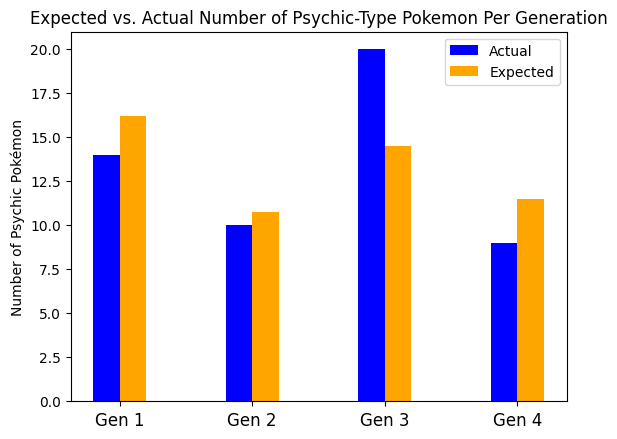

In [35]:
# create a column indicating if a Pokemon has the Psychic type
pokemon_df['is_psychic'] = pokemon_df['types'].apply(lambda x: 'psychic' in x)

# Now create a contingency table comparing generation & Psychic-type status
contingency_table = pd.crosstab(pokemon_df['generation'], pokemon_df['is_psychic'])

# perform chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-Squared Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies Table:")
print(expected)

# plot expected # of Psychic types with the actual # of Psychic types
labels = ['Gen 1', 'Gen 2', 'Gen 3', 'Gen 4']
width = 0.2
x = np.arange(len(labels))
plt.xticks(x, labels, fontsize=12)

expected_psychic = expected[:, 1].tolist()
actual_psychic = [pokemon_df[pokemon_df['generation'] == 1]['is_psychic'].sum(),
                  pokemon_df[pokemon_df['generation'] == 2]['is_psychic'].sum(),
                  pokemon_df[pokemon_df['generation'] == 3]['is_psychic'].sum(),
                  pokemon_df[pokemon_df['generation'] == 4]['is_psychic'].sum()]
plt.bar(x - width/2, actual_psychic, width=width, label='Actual', color='blue', edgecolor=None)
plt.bar(x + width/2, expected_psychic, width=width, label='Expected', color='orange',edgecolor=None)
plt.ylabel("Number of Psychic Pokémon")
plt.title("Expected vs. Actual Number of Psychic-Type Pokemon Per Generation")
plt.legend()
plt.show()


Since the p-value is greater than 0.05, we fail to reject the null hypothesis. There is not sufficient evidence to prove that there is a relationship between generation number and number of Psychic-types released.

## ANOVA Test

We want to see if there is a significant difference between the attributes of the top three pokemon types. To do so we perform an ANOVA test with an alpha of 0.05.

H_0: There is no difference between the attributes of the top three pokemon types.

H_A: There is a difference between the attributes of the top three pokemon types.

In [ ]:
# Finding the top 3 most popular types
pokemon_df['types'].explode() \
                   .value_counts()[:3]

types
water     92
normal    72
flying    64
Name: count, dtype: int64

In [ ]:
# Cleaning attributes to set up for ANOVA
anova_attrs = ['hp', 'attack', 'defense', 'special-attack', 'special-defense', 'speed']

water_types = pokemon_df[pokemon_df['types'].apply(lambda x: any(i == 'water' for i in x))][anova_attrs]
normal_types = pokemon_df[pokemon_df['types'].apply(lambda x: any(i == 'normal' for i in x))][anova_attrs]
flying_types = pokemon_df[pokemon_df['types'].apply(lambda x: any(i == 'flying' for i in x))][anova_attrs]

In [ ]:
# Performing ANOVA test
statistic, pvalue = stats.f_oneway(water_types, normal_types, flying_types)
print(f"Statistic: {statistic}]\nP-value: {pvalue}")

Statistic: [ 1.93045095  0.22567406  7.9856803   7.71162871  2.58241603 11.17270117]]
P-value: [1.47478161e-01 7.98158558e-01 4.46089942e-04 5.76341151e-04
 7.78304526e-02 2.36510839e-05]


In [ ]:
significant_diff = [i < 0.05 for i in pvalue]
significant_diff

[False, False, True, True, False, True]

In [ ]:
anova_attrs

['hp', 'attack', 'defense', 'special-attack', 'special-defense', 'speed']

Here we can see that there exist a significant difference between the defense, special-attack, and speed attributes, we can perform some form of Post-HOC test to see which combinations of types are statistically significant.